In [87]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


In [41]:
x = pd.read_csv('Speed Dating Data.csv', encoding="ISO-8859-1")

In [42]:
x.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1,0,1,1,1,10,7,NaN,4,...,5,7,7,7,7,NaN,NaN,NaN,NaN,NaN
1,1,1,0,1,1,1,10,7,NaN,3,...,5,7,7,7,7,NaN,NaN,NaN,NaN,NaN
2,1,1,0,1,1,1,10,7,NaN,10,...,5,7,7,7,7,NaN,NaN,NaN,NaN,NaN
3,1,1,0,1,1,1,10,7,NaN,5,...,5,7,7,7,7,NaN,NaN,NaN,NaN,NaN
4,1,1,0,1,1,1,10,7,NaN,7,...,5,7,7,7,7,NaN,NaN,NaN,NaN,NaN


In [43]:
def extract_database(filename):
    df = pd.read_csv(filename, encoding="ISO-8859-1")

    # Table of people
    df_p = df.drop_duplicates('iid').set_index('iid').loc[:, 'age':'amb3_1']
    df_p.loc[:, 'attr1_1':'amb3_1'] = df.loc[:, 'attr1_1':'amb3_1'].replace(to_replace=pd.NaT, value=0.0)
    df_p = df_p.drop("mn_sat", axis=1)
    df_p = df_p.drop("undergra", axis=1)
    df_p = df_p.drop("tuition", axis=1)
    df_p = df_p.drop("from", axis=1)
    df_p = df_p.drop("zipcode", axis=1)
    df_p = df_p.drop("income", axis=1)
    df_p = df_p.drop("field", axis=1)
    df_p = df_p.drop("field_cd", axis=1)
    df_p = df_p.drop("career", axis=1)
    df_p = df_p.drop("attr4_1", axis=1)
    df_p = df_p.drop("sinc4_1", axis=1)
    df_p = df_p.drop("intel4_1", axis=1)
    df_p = df_p.drop("fun4_1", axis=1)
    df_p = df_p.drop("amb4_1", axis=1)
    df_p = df_p.drop("shar4_1", axis=1)
    df_p = df_p.dropna(axis=0)

    # Table of meeting and result
    df_m = df.loc[:, ['iid', 'pid', 'match']]
    df_m = df_m[df_m["iid"].isin(list(df_p.index.values))]
    df_m = df_m[df_m["pid"].isin(list(df_p.index.values))]
    df_m = df_m.reset_index(drop=True)

    return df_p, df_m

In [45]:
df_p, df_m = extract_database('Speed Dating Data.csv')

In [50]:
class Normalizer:
    def __init__(self, training_array):
        self.__mini = np.min(training_array, axis = 0)
        maxi = np.max(training_array, axis = 0)
        self.__delta = maxi - self.__mini
        
    def __call__(self, array):
        return np.apply_along_axis(lambda x: (x-self.__mini)/self.__delta, 1, array)

In [52]:
class PCA:
    
    def get_projection_matrix(self, array ,n):
        corr = np.cov(array, rowvar=False)
        v, w = np.linalg.eig(corr)
        
        index = np.argsort(v[::-1])
        return w[:, index[:n]]
    
    def __init__(self, training_array, n):
        self.__proj = self.get_projection_matrix(training_array, n)
        
    def __call__(self, array):
        return self.__proj.T.dot(array.T).T
    

In [53]:
class Preprocess:
    def __init__(self, df, dim):
        self.__df = df 
        self.__norm = Normalizer(self.__df.values)
        self.__red = PCA(self.__norm(self.__df.values), dim)
        
    def __call__(self, iid):
        return self.__red(self.__norm(self.__df.loc[iid, :].values ))

In [72]:
PEOPLE_DIM = 10
HIDDEN = 32
BATCH_SIZE = 60
EPOCHS = 10000

In [76]:
red = Preprocess(df_p.loc[:, 'attr1_1':'amb3_1'], PEOPLE_DIM)
blue = Preprocess(df_p.loc[:, 'date':'yoga'], PEOPLE_DIM)
vectorize = lambda x : np.concatenate((red(x), blue(x)), axis = 1)

In [86]:
def gen_profile():
    gen = df_m.sample(frac=1).reset_index().iterrows()
    for j in range(EPOCHS):
        iid, pid, match = [], [], []
        for i in range(BATCH_SIZE):
            try:
                row = next(gen)[1]
            except StopIteration:
                gen = df_m.sample(frac=1).reset_index().iterrows()
                row = next(gen)[1]
            iid.append(int(row.loc['iid']))
            pid.append(int(row.loc['pid']))
            match.append(row.loc['match'])
        
        yield np.float32(match).reshape([BATCH_SIZE, 1]), vectorize(iid), vectorize(pid)

In [95]:
# Placeholders
iid_ph = tf.placeholder(np.float32, shape=[None, PEOPLE_DIM*2])
pid_ph = tf.placeholder(np.float32, shape=[None, PEOPLE_DIM*2])
match_ph = tf.placeholder(np.float32, shape=[None, 1])

# Model
cont_ab = tf.concat((pid_ph, iid_ph), axis=1)
cont_ba = tf.concat((iid_ph, pid_ph), axis=1)

w_1 = tf.Variable(tf.truncated_normal([PEOPLE_DIM*4, HIDDEN], stddev=0.1))
b_1 = tf.Variable(tf.truncated_normal([HIDDEN], stddev=0.1))
l_h_ab = tf.nn.softplus(tf.matmul(cont_ab, w_1) + b_1)
l_h_ba = tf.nn.softplus(tf.matmul(cont_ba, w_1) + b_1)

w_2 = tf.Variable(tf.truncated_normal([HIDDEN, 1], stddev=0.1))
b_2 = tf.Variable(tf.truncated_normal([1], stddev=0.1))
l_2 = tf.matmul(l_h_ab, w_2) + tf.matmul(l_h_ba, w_2) + b_2
logits = tf.sigmoid(l_2)

# Trainer
print("Total vars: ~{:.2f}k\n".format((4*PEOPLE_DIM*HIDDEN + 2*HIDDEN + 1)/1000))
global_step = tf.Variable(0, trainable=False)
learing_rate = tf.train.exponential_decay(0.1, global_step, 1000, 0.8, staircase=True)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_2, labels=match_ph))
trainer_step = tf.train.MomentumOptimizer(learing_rate, 0.9).minimize(loss, global_step=global_step)

Total vars: ~1.34k



In [96]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    # Train the model
    print("Training...")
    i = 0
    for profile in gen_profile():
        trainer_step.run(feed_dict={iid_ph: profile[1], pid_ph: profile[2], match_ph: profile[0]})

        if i % 1000 == 0:
            print(loss.eval(feed_dict={iid_ph: profile[1], pid_ph: profile[2], match_ph: profile[0]}))
        i += 1
    print("\n")

    # Let's find love <3
    # It fill a lookup table, it's not the goal, but it's useful to dispay results
    print("Looking for hope...")
    l_df_p = len(df_p)
    mp = np.ndarray((l_df_p, l_df_p), dtype=np.float32)  # Map of result
    for i in range(l_df_p):
        pid = df_p.index[i]
        for j in range(l_df_p):
            iid = df_p.index[j]
            mp[i, j] = logits.eval(feed_dict={iid_ph: vectorize([iid]), pid_ph: vectorize([pid])})[0, 0]
    print("Done")

Training...
0.555473
0.402246
0.469121
0.219161
0.350761
0.310757
0.116561
0.170278
0.232584
0.295706


Looking for hope...
Done


In [97]:

# Model Testing
def find(i):
    n = 0
    for j in list(df_p.index):
        if i==j:
            return n
        n += 1
        
error = 0.0
for index, rows in df_m.iterrows():
    error += abs(rows["match"] - mp[find(rows["iid"]), find(rows["pid"])])
print("Avg error: {:.2f}%".format(100 * error / len(df_m)))

Avg error: 12.67%


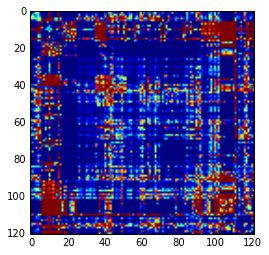

In [98]:

# Display the Love map
plt.imshow(mp)
plt.show()